# Libraries | Install

In [54]:
!pip install torch sklearn numpy matplotlib tqdm torchviz ann_visualizer torchsummary --quiet

You should consider upgrading via the '/Users/fermibot/PycharmProjects/python-projects/venv/bin/python -m pip install --upgrade pip' command.


# Libraries | Import

In [55]:
import torch
from sklearn.linear_model import LinearRegression
from random import random, randint, choice, normalvariate
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchviz import make_dot
from torchsummary import summary
import pandas as pd

# Functions | Define

In [56]:
def randomize(factor):
    return choice([-1, 1]) * factor * random()


class Config:
    x_n = 25  # NUMBER OF INPUT VARIABLES
    lr = 0.01
    epochs = 10
    split_train = 0.8
    shuffle = True
    batch_size = 64
    device = torch.device("mps")


def print_separator():
    print("\n" + "-" * 100)


config = Config()

# Dataset | Synthesize

$Y_j = \underset{i}{\Sigma} c_{ij}*x_{ij} \mid c_i = 0.1, 0.2, 0.3 ...$

In [57]:
seed_list = [random() for x in range(2 ** 14)]
x_n = config.x_n
coe = [0.1 * x for x in range(1, x_n + 1)]
coe

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2000000000000002,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.8,
 1.9000000000000001,
 2.0,
 2.1,
 2.2,
 2.3000000000000003,
 2.4000000000000004,
 2.5]

<Axes: xlabel='original', ylabel='1'>

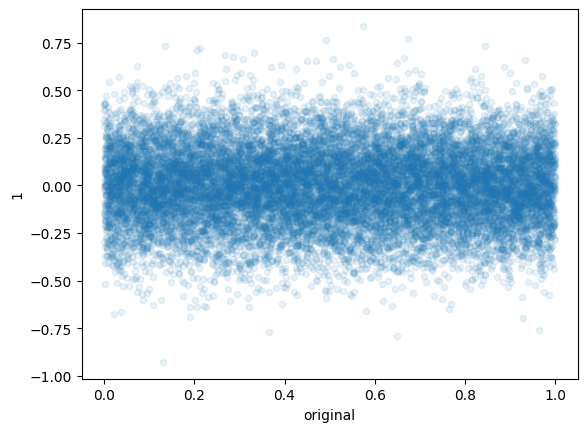

In [58]:
X = [[x + randomize(0.01) for y in range(1, x_n + 1)] for x in seed_list]

X = [[normalvariate() for coe_x in coe] for x in seed_list]
X_y = [[x_i * coe_j + randomize(0.01) for x_i, coe_j in zip(x, coe)] for x in X]
y = [sum([x_i * coe_j + randomize(0.01) for x_i, coe_j in zip(x, coe)]) for x in X]

df = pd.DataFrame(X_y)
df['original'] = seed_list
df.plot.scatter(x='original', y=1, alpha=0.1)

# Modeling | Linear Regression

## $y_i = 0.1 * x_{1i} + 0.2 * x_{2i} + 0.3 * x_{3i} + 0.4 * x_{4i} ...$

In [59]:
lr = LinearRegression()
lr.fit(X, y)

print(f"\nCoefficients: {lr.coef_}")
print(f"\nIntercept: {lr.intercept_}")


Coefficients: [0.10032646 0.20030561 0.30011175 0.40010253 0.50003433 0.59980187
 0.70007987 0.79938362 0.90004518 1.00012398 1.09998486 1.20007433
 1.29968255 1.40010972 1.49996186 1.59998212 1.70006226 1.80021268
 1.8998073  2.00022464 2.09957428 2.20002776 2.29988858 2.39995206
 2.50002371]

Intercept: -0.00012851451743352976


# $R^2 = 1 - \frac{u}{v}$

- $\mid u = \Sigma ({y_{true} - y_{pred}})^2$
- $\mid v = \Sigma ({y_{true} - y_{mean}})^2$


In [60]:
print(f"\nFit score: {lr.score(X, y)}")


Fit score: 0.9999847073367802



# Modeling | Neural Network

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [62]:
tensor_X = torch.tensor(X, dtype=torch.float32, device=config.device)
tensor_y = torch.tensor(y, dtype=torch.float32, device=config.device)

size_train = int(config.split_train * len(tensor_X))
size_test = len(tensor_X) - size_train
assert size_train + size_test == len(tensor_X)

dataset_train = TensorDataset(tensor_X[:size_train], tensor_y[:size_train])
dataset_test = TensorDataset(tensor_X[size_train:], tensor_y[size_train:])

loader_train = DataLoader(dataset=dataset_train, batch_size=config.batch_size)
loader_test = DataLoader(dataset=dataset_test, batch_size=config.batch_size)

In [63]:
class LinearModel(nn.Module):
    def __init__(self, in_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=1, bias=True)

    def forward(self, x):
        return self.linear(x)


model = LinearModel(in_features=config.x_n)
summary(model, input_size=(config.x_n,), device='cpu')
model.to(device=config.device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]              26
Total params: 26
Trainable params: 26
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


LinearModel(
  (linear): Linear(in_features=25, out_features=1, bias=True)
)

## Modeling | Linear Regression | Neural Network | Train

In [64]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=config.lr)
loss_all = []

for epoch in tqdm(range(config.epochs)):
    loss_epoch_train = 0.0
    for batch_X, batch_y in loader_train:
        outputs = model(batch_X)
        loss_batch = criterion(outputs, batch_y.unsqueeze(1))
        loss_epoch_train += loss_batch

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    loss_all.append(loss_epoch_train)


  0%|          | 0/10 [00:00<?, ?it/s]

## Modeling | Linear Regression | Neural Network | Evaluate

In [65]:
model.eval()
with torch.no_grad():
    # Get the learned parameters
    weights_nn = model.linear.weight.detach().cpu().numpy().flatten()
    bias = model.linear.bias.detach().cpu().numpy().flatten()[0]

In [66]:
df_weights = pd.DataFrame(
    {"coeffs_original": coe, "coeffs_lr": lr.coef_, "coeffs_lr_delta": abs(lr.coef_ - coe), "weights_nn": weights_nn,
     "weights_nn_delta": abs(weights_nn - coe)})

df_weights

,coeffs_original,coeffs_lr,coeffs_lr_delta,weights_nn,weights_nn_delta
0,0.1,0.100326,0.000326,0.100184,0.000184
1,0.2,0.200306,0.000306,0.200043,0.000043
2,0.3,0.300112,0.000112,0.300506,0.000506
3,0.4,0.400103,0.000103,0.400159,0.000159
4,0.5,0.500034,0.000034,0.500101,0.000101
5,0.6,0.599802,0.000198,0.599933,0.000067
6,0.7,0.700080,0.000080,0.699758,0.000242
7,0.8,0.799384,0.000616,0.799309,0.000691
8,0.9,0.900045,0.000045,0.900090,0.000090
9,1.0,1.000124,0.000124,1.000370,0.000370


Sum of weights and $\delta s$

In [67]:
pd.DataFrame({'sum': df_weights.aggregate(func='sum')})

,sum
coeffs_original,32.500000
coeffs_lr,32.499884
coeffs_lr_delta,0.003846
weights_nn,32.499966
weights_nn_delta,0.006370


# Modeling | Compare

In [68]:
model.eval()
with torch.no_grad():
    y_pred_pytorch = model(tensor_X).cpu().numpy().flatten()
    y_true = tensor_y.cpu().numpy().flatten()

# Sklearn predictions
X_np = np.array(X)
y_np = np.array(y)
y_pred_sklearn = lr.predict(X_np)

# Calculate R² scores
r2_pytorch = r2_score(y_true, y_pred_pytorch)
r2_sklearn = r2_score(y_true, y_pred_sklearn)

# Get model parameters
weights = model.linear.weight.detach().cpu().numpy().flatten()
bias = model.linear.bias.detach().cpu().numpy().flatten()[0]

# Side-by-side comparison

print("MODEL COMPARISON SUMMARY")
print_separator()
print(f"{'Metric':<25} {'Sklearn':<15} {'PyTorch':<15} {'True':<10}")
print_separator()
print(f"{'R² Score':<25} {r2_sklearn:<15.6f} {r2_pytorch:<15.6f} {'-':<10}")
print(f"{'Sum of Weights':<25} {np.sum(lr.coef_):<15.6f} {np.sum(weights):<15.6f} {np.sum(coe):<10.6f}")
print(f"{'Bias/Intercept':<25} {lr.intercept_:<15.6f} {bias:<15.6f} {'0.0':<10}")
print_separator()


# Quality assessment
def get_quality(r2):
    if r2 > 0.9:
        return "Excellent"
    elif r2 > 0.7:
        return "Good"
    elif r2 > 0.5:
        return "Fair"
    else:
        return "Poor"


print(f"{'Fit Quality':<25} {get_quality(r2_sklearn):<15} {get_quality(r2_pytorch):<15} {'-':<10}")
print(f"{'Variance Explained':<25} {r2_sklearn * 100:<14.1f}% {r2_pytorch * 100:<14.1f}% {'-':<10}")

MODEL COMPARISON SUMMARY

----------------------------------------------------------------------------------------------------
Metric                    Sklearn         PyTorch         True      

----------------------------------------------------------------------------------------------------
R² Score                  0.999985        0.999985        -         
Sum of Weights            32.499884       32.499966       32.500000 
Bias/Intercept            -0.000129       -0.000393       0.0       

----------------------------------------------------------------------------------------------------
Fit Quality               Excellent       Excellent       -         
Variance Explained        100.0         % 100.0         % -         
